### 0 - Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy import stats
import math
import pandas as pd
import ipywidgets
from scipy.optimize import curve_fit
import plotly.express as px
from numpy import mean, std

#from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, scale_x_continuous, scale_y_continuous
#from plotnine.data import mpg

### 1 - Import data paths

In [40]:
# Data paths
path="C:/Users/omeru/Documents/Omer_Repos/Internship Pascal/analysis/data/"
data_Erva="erva50_pilot_base_expectation_shapes_perceived_time_2023-03-16_23h46.19.804.csv" # no expectation
data_Erva_70="erva07_expectation_shapes_perceived_time_2023-03-23_20h55.33.677.csv"
data_Erva80="erva80G_expectation_shapes_perceived_time_2023-04-07_23h25.04.855.csv"

data_nicola_85_1="nicola_85_1_expectation_shapes_perceived_time_2023-03-28_15h04.34.263.csv"
data_Nicola=  'nicola_base_pilot_expectation_shapes_perceived_time_2023-03-20_15h03.16.305.csv'# no expectation

data_Omer="299271_expectation_shapes_perceived_time_2023-03-19_15h42.48.633.csv" # no expectation
data_Omer2="omer85_high_exp_expectation_shapes_perceived_time_2023-03-17_12h35.14.339.csv" # expectation
data_omer_70="omer70_expectation_shapes_perceived_time_2023-03-27_21h43.36.152.csv" #expected 70 percent
data_omer_80G="omer80G_expectation_shapes_perceived_time_2023-04-03_14h30.36.416.csv" #expected 80 percent

data_elaine80R="elaine08R_expectation_shapes_perceived_time_2023-04-13_17h14.41.421.csv" #expected 80 percent

data_marika="marika_expectedh2_expectation_shapes_perceived_time_2023-04-28_16h29.23.427.csv"

data_ahmed_high="ahmed_high0_cont_expectation_shapes_perceived_time_2023-04-29_14h47.24.687.csv"
data_ahmed_base="ahmed_base01_expectation_shapes_perceived_time_2023-04-29_13h16.43.447.csv"

data_sarah_base="sarah_base0_expectation_shapes_perceived_time_2023-04-29_15h33.10.161.csv"
data_sarah_high="sarah_high1_expectation_shapes_perceived_time_2023-04-29_16h58.53.797.csv"
datas_expecataions_80=[data_Erva80,data_omer_80G,data_elaine80R,data_marika,data_sarah_high,data_ahmed_high,data_ahmed_base,data_sarah_base]

### 2 - Clean Data

In [41]:
xAxisTicks=[-0.300 , -0.233, -0.167, -0.100 , -0.033, 0.033, 0.100 ,0.167, 0.233, 0.300]
def outlier_remover(data,variable):
    mean_tmp, std_tmp=data[variable].mean(), data[variable].std()
    rows_to_delete_lower = data[data["pTemporalError"]<mean_tmp-1.5*std_tmp].index
    rows_to_delete_upper = data[data["pTemporalError"]>mean_tmp+1.5*std_tmp].index
    data = data.drop(rows_to_delete_lower)
    data = data.drop(rows_to_delete_upper)
    return data
def modelPerceivedTime2(x,alpha,beta):
    return alpha*np.sin(1*math.pi*x)+beta*x
def clean_data(datam):
    datam["delayS"]=datam["delay"]/1000
    datam["pTemporalError"]=datam["perceivedTime"]-datam["target.started"]# Calculate temporalError
    datam["pTemporalErrorMs"]=datam["pTemporalError"]*1000
    datam["physicalDelay"]=datam["distractor.started"]-datam["target.started"]
    datam["physicalDelayMs"]=datam["physicalDelay"]*1000
    datam["rt_total"]=datam["responsePointer.stopped"]-datam["responsePointer.started"]
    return datam



# Clean and prepare data for analysis

In [122]:
# create a blank dataframe with column names
datas = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","responseStarted"])
for data in datas_expecataions_80:
    df=pd.read_csv(path+data)
    df=clean_data(df)
    df=outlier_remover(df,"pTemporalError")
    # select only the relevant columns
    df=df[["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
           "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","responseStarted"]]
    # row bind the dataframes
    datas = pd.concat([datas, df], ignore_index=True)
    


In [120]:
datas=datas[datas["target.started"].notna()]
datas=datas[datas["perceivedTime"].notna()]
df_test=datas[datas["isTrial"]=="testSingleStim"]
##### fit data to model
df_tmp=df_test
## Remove the outliers
df_tmp=outlier_remover(df_tmp,"pTemporalError")
## fit model to to perceived time
x=datas["target.started"]
x=x.astype(float)
y=datas["perceivedTime"]
y=y.astype(float)
parameters, covariance = curve_fit(modelPerceivedTime2, x,y)
fit_A , fit_B = parameters[0] , parameters[1]
preditcedPerceivedTime = modelPerceivedTime2(df["target.started"], fit_A, fit_B)
## assign new variables to df
datas["predictedPerceivedTime"]=preditcedPerceivedTime # take fitted perceived time to the data
datas["pTemporalErrorFitted"]=datas["perceivedTime"]-datas["predictedPerceivedTime"] # calculate temporal error based on predicted time

avgError=np.mean(df_test["perceivedTime"]-df_test["target.started"])
datas["pTemporalErrorAvaraged"]=datas["pTemporalError"]-avgError
## assign datas to self
datas=datas[datas["pTemporalError"].notna()]
df_trial=datas[datas["isTrial"]=="trial"]
df_trial=datas
df_long=df

df_unmet=datas[datas["congruency"]=="unmet"]
df_met=datas[datas["congruency"]=="met"]

In [123]:
datas.to_csv("datas.csv")

In [88]:
# Get meaans grouped by constant target-distractor delay
def get_means(data):
	#df=clean_data(data=data_Erva)
	df_means=data.groupby('delayS').median()
	df_stdDev=data.groupby("delayS").std()
	a=list(df_means["delay"].unique())
	a.sort()
	df_means["delayMs"]=a
	del a
	xdata=df_means["physicalDelay"]
	ydata=df_means["pTemporalErrorFitted"]
	return xdata, ydata

In [90]:

def model_time_base(delay,alpha,sigma):
	modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2) for x in delay]
	return modelPerceivedError
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+teta for x in delay]
    return modelPerceivedError
def model_expectation_met(delay,alpha,sigma,delta,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**4)+teta for x in delay]
    return modelPerceivedError
def model_expectation_unmet(delay,alpha,sigma,teta,delta=1):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**5)+teta for x in delay]
    return modelPerceivedError    


## fit model to to perceived time

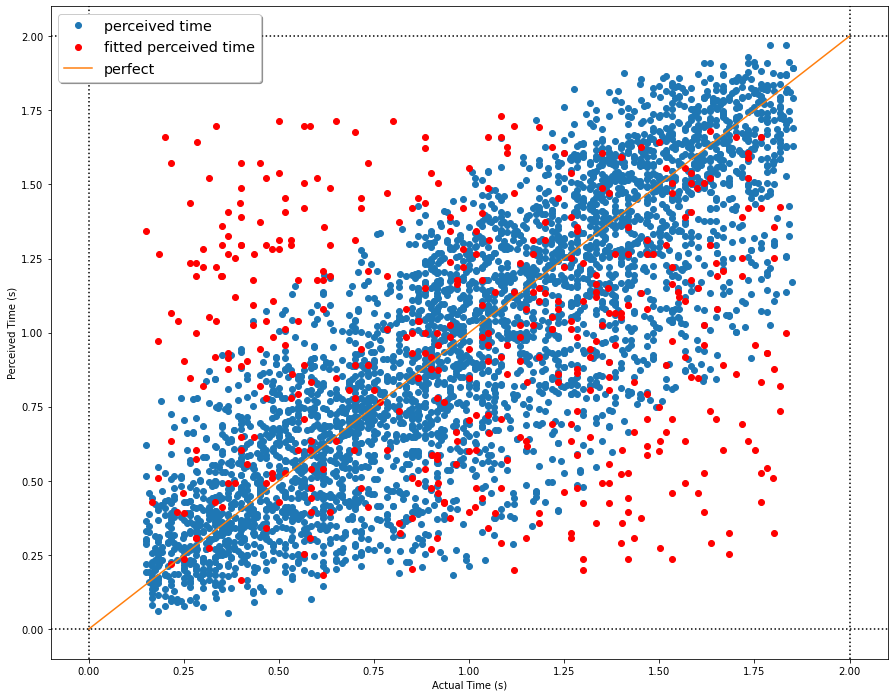

In [78]:
def modelPerceivedTime(x,alpha,beta):
    return alpha*np.sin(1*math.pi*x)+beta*x

def plot_perceived_actual(df_trial):
    plt.figure(figsize=(15, 12))
    plt.plot(datas["target.started"],datas["perceivedTime"],'o',label="perceived time")
    plt.plot(datas["target.started"],datas["predictedPerceivedTime"].astype(float),'ro',label="fitted perceived time")
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect")
    #sns.regplot(datas["target.started"],datas["perceivedTime"].astype, ci=None,label="regression")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    #plt.title("Perceived time vs actual time for Test trials of "+datas.split('_')[0])
    plt.ylabel("Perceived Time (s)")
    plt.xlabel("Actual Time (s)")
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas)

In [106]:
fitter()

KeyError: 'delay'

In [118]:
mets=fitter(means=0,congruency="met",dfi=datas)
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=fitter(means=0,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])
#a.plotter(x,fit_y,xdata,ydata,congruency
def plot_mets_unmets(mets,unmets):
    plt.figure(figsize=(15, 12))
    plt.plot(mets[2], mets[3], 'o', label='met data',color='red')
    plt.plot(unmets[2], unmets[3], 'o', label='unmet data',color='green')

    plt.plot(mets[0], mets[1], '-', label='met fit',color='red')
    plt.plot(unmets[0], unmets[1], '-', label='unmet fit',color='green')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydatak, ci=None,label="regression")
    #plt.title("Temporal errors of "+df_obj.data_name.split('_')[0]+" met vs unmet")
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    lim=0.4
    plt.ylim(-lim, +lim)
    plt.yticks(list(np.linspace(-lim,lim,11)))
    #plt.yticks(10)
    plt.xticks(xAxisTicks)
    plt.legend()
    plt.show()

mets=fitter(means=1,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=fitter(means=1,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])  
plot_mets_unmets(mets,unmets)
mets=fitter(means=0,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=fitter(means=0,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])
plot_mets_unmets(mets,unmets)

ValueError: array must not contain infs or NaNs

In [116]:
def plot_base_model(means,plotly=False):
    if means==True:
        xdata,ydata=get_means(df_trial)
    else:
        xdata,ydata=df_trial["physicalDelay"],df_trial["pTemporalErrorFitted"]
    #parameters, covariance = curve_fit(model_time_base, xdata, ydata)
    parameters, covariance = curve_fit(modelPTime, xdata, ydata)
    fit_A, fit_B = parameters[0], parameters[1]
    #print(fit_A,fit_B)
    middleInt=np.linspace(-0.35,0.35,100)
    fit_k = modelPTime(middleInt, fit_A, fit_B,parameters[2])
    ## Plot using matplotlib
    plt.figure(figsize=(15, 12))
    plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(middleInt, fit_k, '-', label='fit')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    sns.regplot(xdata, ydata, ci=None,label="regression")
    #plt.title("Temporal errors of "+data_name.split('_')[0])
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    plt.ylim(-0.4,0.4)
    plt.yticks(list(np.linspace(-0.4,0.4,11)))
    plt.xticks(xAxisTicks)
    plt.legend()
    SE = np.sqrt(np.diag(covariance))
    SE_A , SE_B= SE[0], SE[1]
    #print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}.')
    #print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}.')

def fitter(means=1,congruency="met",dfi=datas):
    df=dfi
    df_to_fit=df[df["congruency"]==congruency]
    df_to_fit=df[df["pTemporalError"]<2]
    df_to_fit=df[df["pTemporalError"]>-2]
    #df_to_fit=outlier_remover(df_to_fit,"pTemporalError")
    if means==True:  xdata,ydata=get_means(df)
    else:  xdata,ydata=df["physicalDelay"],df["pTemporalErrorFitted"]
    x=x=np.linspace(min(xdata),max(xdata),200)
    if congruency=="met":   
        params, covariance = curve_fit(model_expectation_met, xdata.astype(float), ydata.astype(float))
        fited_errors = model_expectation_met(x, params[0],params[1],params[2],params[3])
    else:
        params, covariance = curve_fit(model_expectation_unmet, xdata, ydata,maxfev=2000)
        fited_errors = model_expectation_unmet(x, params[0],params[1],params[2],params[3])
    fit_alpha,fit_sigma,fit_teta= params[0],params[1],params[2]
    np.sqrt(np.diag(covariance))
    print(np.sqrt(np.diag(covariance)))
    print("for "+congruency+" condition fit alpha is :" +str(fit_alpha)+" fit sigma is :"+str(fit_sigma)+"fit teta : "+ str(fit_teta))
    return x,fited_errors,xdata,ydata,congruency
def plotter(x,fit_y,xdata,ydata,congruency,df=datas):
    plt.figure(figsize=(15, 12))
    plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(x, fit_y, '-', label='fit')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydatak, ci=None,label="regression")
    plt.title("Temporal errors of "+data_name.split('_')[0]+congruency+" trials")
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    plt.ylim(-0.3, +0.3)
    plt.yticks(list(np.linspace(-0.35,0.35,11)))
    #plt.yticks(10)
    plt.xticks(xAxisTicks)
    plt.legend()

def perceived_actual(data):
    plt.figure(figsize=(15, 12))
    y=df_trial["perceivedTime"]
    x=df_trial["target.started"]
    plt.plot(x,y,'o')
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100))
    sns.regplot(x, y, ci=None)